# EECE 571T Project - NLP with Emotion Dataset (BERT)

Focus: BERT
<br>
Author: Tom Sung

Last updated:
* Date: March 11, 2022
* Time: 1:37pm

In [ ]:
# Check detected system hardware resources.
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

TensorFlow version: 2.8.0
Num GPUs Available:  1
Num CPUs Available:  1


## References

* Text Classification tutorial: https://github.com/adsieg/Multi_Text_Classification
* From same author:
    * [**Feb.17**] This is used for the Word Embedding part: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794 (Try following these instructions next)
    * [**Feb.17**] https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d
* Different Pre-Processing Techniques with Bag of Words w/ TF-IDF, Word Embedding, and BERT: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

## Get data from GitHub repo

**Only run this once even after if notebook environment is cleared via** `%reset -f`. The code written here imports the Kaggle data set, which I have placed on my public GitHub repo.

In [ ]:
!wget https://github.com/tkjsung/EECE571T_Dataset/archive/refs/heads/master.zip
!unzip /content/master.zip
# For local computer use:
# !unzip master.zip

--2022-03-11 23:51:15--  https://github.com/tkjsung/EECE571T_Dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/tkjsung/EECE571T_Dataset/zip/refs/heads/master [following]
--2022-03-11 23:51:15--  https://codeload.github.com/tkjsung/EECE571T_Dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [  <=>               ] 798.87K  3.41MB/s    in 0.2s    

2022-03-11 23:51:16 (3.41 MB/s) - ‘master.zip’ saved [818042]

Archive:  /content/master.zip
f84fef58c648047c03c671498e0375bf224f000e
   creating: EECE571T_Dataset-master/
  inflating: EE

## Import Data

In [ ]:
# Import libraries for data import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [ ]:
# Read CSV
# data_train = pd.read_csv('/content/EECE571T_Dataset-master/Project/train.txt',sep=';', header=None)
# data_test = pd.read_csv('/content/EECE571T_Dataset-master/Project/test.txt',sep=';', header=None)
# data_val = pd.read_csv('/content/EECE571T_Dataset-master/Project/val.txt',sep=';', header=None)

# Read CSV on local computer
data_train = pd.read_csv('EECE571T_Dataset-master/Project/train.txt',sep=';', header=None)
data_test = pd.read_csv('EECE571T_Dataset-master/Project/test.txt',sep=';', header=None)
data_val = pd.read_csv('EECE571T_Dataset-master/Project/val.txt',sep=';', header=None)

In [ ]:
col_names = ["sentence","emotion"]
data_train.columns = col_names
data_test.columns = col_names
data_val.columns = col_names

In [ ]:
# See the data head to make sure data is imported correctly.
data_train.head()
# data_test.head()
# data_val.head()

,sentence,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## Encode the emotion labels with unique identifiers

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Encode the emotion labels with unique identifiers
data_train['emotion'].unique()
labelencoder = LabelEncoder()
data_train['emotion_enc'] = labelencoder.fit_transform(data_train['emotion'])
data_test['emotion_enc'] = labelencoder.fit_transform(data_test['emotion'])
data_val['emotion_enc'] = labelencoder.fit_transform(data_val['emotion'])
# For data_test and data_val, use the same labelencoder. Make sure it's the same by using the display code below.

Display the encoded emotion labels

In [ ]:
data_train[['emotion','emotion_enc']].drop_duplicates(keep='first')
# data_test[['emotion','emotion_enc']].drop_duplicates(keep='first')
# data_val[['emotion','emotion_enc']].drop_duplicates(keep='first')

,emotion,emotion_enc
0,sadness,4
2,anger,0
3,love,3
6,surprise,5
7,fear,1
8,joy,2


[OLD-Don't need this] ~Add sentence length to each sentence. It should calculate number of characters, including spaces and punctuation.~

In [ ]:
# data_train['length'] = [len(x) for x in data_train['sentence']]
# data_test['length'] = [len(x) for x in data_test['sentence']]
# data_val['length'] = [len(x) for x in data_val['sentence']]

In [ ]:
data_train.head()
data_test.head()
data_val.head()

,sentence,emotion,emotion_enc
0,im feeling quite sad and sorry for myself but ...,sadness,4
1,i feel like i am still looking at a blank canv...,sadness,4
2,i feel like a faithful servant,love,3
3,i am just feeling cranky and blue,anger,0
4,i can have for a treat or if i am feeling festive,joy,2


[OLD-Unncessary] ~Finding the maximum sentence length. It seems to be 300. From the testing and validation set, they are 296 and 295, respectively.~

In [ ]:
# max_len = data_train['length'].max()
# print(max_len)

## Data Cleaning

We need to do some data cleaning first~, otherwise it would be a nightmare to do pre-processing with at least 15212 vocabulary words...~

**Data Cleaning Process:** Keep only words, convert all words to lowercase, split all words, remove stopwords, lemmization for word root.<br>
The result of all of this work is a cleaned data vocab list.

Replace stemming with lemmization, which keeps the actual form of the word better. This is necessary for using pre-existing word embedding models.
Source: https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/

In [ ]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Attempting data cleaning here
def preprocess(raw_text):
    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

    # convert to lower case and split 
    words = letters_only_text.lower().split()

    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    meaningful_words = [w for w in words if w not in stopword_set]
    
    # stemmed words (looks like this is causing some words to be weird)
    # ps = PorterStemmer()
    # stemmed_words = [ps.stem(word) for word in meaningful_words]

    # lemmed words (trying this because this gets the root word?)
    lem = WordNetLemmatizer()
    lemmed_words = [lem.lemmatize(word) for word in meaningful_words]
    
    # join the cleaned words in a list
    # cleaned_word_list = " ".join(stemmed_words)
    cleaned_word_list = " ".join(lemmed_words)
    # cleaned_word_list = " ".join(meaningful_words)

    return cleaned_word_list

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


Apply data cleaning to all data sets.

In [ ]:
data_train['sentence_cleaned'] = data_train['sentence'].apply(lambda line : preprocess(line))
data_test['sentence_cleaned'] = data_test['sentence'].apply(lambda line : preprocess(line))
data_val['sentence_cleaned'] = data_val['sentence'].apply(lambda line : preprocess(line))

## Pre-Processing and Training

Pre-processing and training is bundled together as the different methods use different pre-processing steps.<br>
There are several methods available: Bag-of-words with TF-IDF, Word Embedding using ~Word2Vec~ [I used GloVe, not Word2Vec] (unknown NN), and BERT.

### METHOD 2: BERT


#### BERT Model (Using Google's Tensorflow Tutorial)

[Link](https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb#scrollTo=_OoF9mebuSZc)

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 462 kB 37.2 MB/s 
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 352 kB 45.7 MB/s 
     |████████████████████████████████| 99 kB 7.2 MB/s 
     |████████████████████████████████| 234 kB 45.4 MB/s 
     |████████████████████████████████| 596 kB 48.3 MB/s 
     |████████████████████████████████| 47.8 MB 55 kB/s 
     |████████████████████████████████| 1.2 MB 38.9 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 1.1 MB 28.4 MB/s 
     |████████████████████████████████| 90 kB 8.4 MB/s 


Defining Model

In [ ]:
# Get BERT Model

# bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'

# 
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

# These will be used in the NN model. These will be layers in the NN model
# bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess) # This is the pre-processing model
# bert_model = hub.KerasLayer(tfhub_handle_encoder) # This is the actual BERT model

In [ ]:
def build_classifier_model():
    # Input
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='txt')

    # BERT Pre-Processing Layer
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing') # This is the pre-processing model
    encoder_inputs = bert_preprocess_model(text_input)

    # BERT Model Layer
    bert_model = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder') # This is the actual BERT model
    outputs = bert_model(encoder_inputs)

    # Fine-tuning. First, Average pooling
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(6, activation='softmax', name='classifier')(net)
    model = tf.keras.Model(text_input, net)
    return model

In [ ]:
classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))

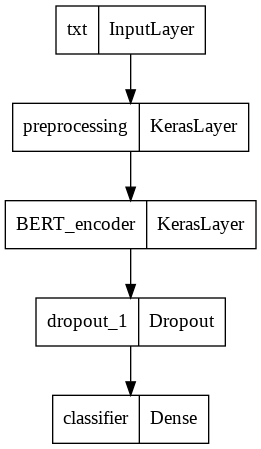

In [ ]:
tf.keras.utils.plot_model(classifier_model)

Loss Function

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = tf.metrics.SparseCategoricalAccuracy()

Optimizer

In [ ]:
# epochs = 5
# init_lr = 3e-5
# num_train_steps = 1
# optimizer = optimization.create_optimizer(init_lr=init_lr,
#                                           num_train_steps=1,
#                                           num_warmup_steps=0,
#                                           optimizer_type='adamw')

Build Model

In [ ]:
classifier_model.compile(optimizer='adam',
                         loss=loss,
                         metrics=['accuracy', tf.metrics.SparseCategoricalAccuracy()])

classifier_model.summary()

# model.compile(loss='sparse_categorical_crossentropy', 
#               optimizer='adam',
#             #   optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
#               metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 txt (InputLayer)               [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['txt[0][0]']                    
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [ ]:
# print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=data_train["sentence_cleaned"], y=data_train['emotion_enc'],
                               batch_size=100, epochs=3, verbose=1,
                               validation_data=[data_val["sentence_cleaned"], data_val['emotion_enc']])



# history = model.fit(x=X_train, y=data_train['emotion_enc'], batch_size=100, epochs=1,
#                     shuffle=True, verbose=1, callbacks=get_callbacks(),
#                     validation_data=[X_val, data_val['emotion_enc']])

Epoch 1/3
160/160 [==============================] - 162s 971ms/step - loss: 0.6526 - accuracy: 0.7685 - sparse_categorical_accuracy: 0.7685 - val_loss: 0.3042 - val_accuracy: 0.8885 - val_sparse_categorical_accuracy: 0.8885
Epoch 2/3
160/160 [==============================] - 164s 1s/step - loss: 0.2530 - accuracy: 0.9050 - sparse_categorical_accuracy: 0.9050 - val_loss: 0.2708 - val_accuracy: 0.8935 - val_sparse_categorical_accuracy: 0.8935
Epoch 3/3
160/160 [==============================] - 161s 1s/step - loss: 0.1780 - accuracy: 0.9274 - sparse_categorical_accuracy: 0.9274 - val_loss: 0.3042 - val_accuracy: 0.8970 - val_sparse_categorical_accuracy: 0.8970


##### Test

This is test for the imported BERT model. Just for show. It won't be used for the NN itself.

In [ ]:
# text_test = list([['this is such an amazing movie!'],['that was a disaster.']])
text_test = ['this is such an amazing movie']
text_preprocessed = bert_preprocess_model(text_test)
# text_preprocessed = bert_preprocess_model(data_train["sentence_cleaned"])

bert_results = bert_model(text_preprocessed)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  102    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]
Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[-0.99999577  0.1015164  -0.9988635   0.99792325 -0.9998011   0.9292674
 -0.9938249  -0.98257816  0.06439658  0.03355096 -0.7638861  -0.05925441]
Sequence Outputs Shape:(1, 128, 128)
Sequence Outputs Values:[[-0.06242192 -1.0242287  -2.6087496  ... -0.85842264 -2.0891283
  -0.19394624]
 [-1.1977322  -0.30312902  0.4389882  ... -2.364897   -1.7449431
   0.24714968]
 [-0.9510959  -0.2639731   0.25630438 ... -1.5122575  -1.9203639
   0.0928443 ]
 ...
 [-0.22765982 -0.68478173  0.4465809  ... -1.9320936  -1.8750236
   1.3991177 ]
 [ 0.4509836  -0.820126    0.45189857 ... -2.2655625  -1.6035308
   0.4130368 ]
 [ 0.4853907

#### BERT Model (Using HuggingFace transformers library)

In [ ]:
!pip install transformers
import transformers

     |████████████████████████████████| 3.8 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 42.3 MB/s 
     |████████████████████████████████| 6.5 MB 39.2 MB/s 
     |████████████████████████████████| 895 kB 38.8 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import pipeline

# BERT tokenizer
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-uncased', num_labels=6, do_lower_case=True)
# tokenizer = transformers.AutoTokenizer.from_pretrained("prajjwal1/bert-tiny", num_labels=6, do_lower_case=True)
# test_nlp_recognizer = pipeline("sentiment-analysis", model="prajjwal1/bert-tiny")

# BERT Model
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
# config = transformers.AutoConfig(dropout=0.2, attention_dropout=0.2)
# config = transformers.AutoConfig.from_pretrained("prajjwal1/bert-tiny", hidden_dropout_prob=0.2)
config.output_hidden_states = False

nlp = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)
# nlp = transformers.AutoModel.from_pretrained("prajjwal1/bert-tiny", config=config)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


From the website (https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794): <br>
*First of all, we need to select the sequence max length. This time I’m gonna choose a much larger number (i.e. 50) because BERT splits unknown words into sub-tokens until it finds a known unigrams. For example, if a made-up word like “zzdata” is given, BERT would split it into [“z”, “##z”, “##data”]. Moreover, we have to insert special tokens into the input text, then generate masks and segments. Finally, put all together in a tensor to get the feature matrix that will have the shape of 3 (ids, masks, segments) x Number of documents in the corpus x Sequence length*

So a summary of the large paragraph above:
In BERT, we have three things to keep track of
1. Token ID: The "regular" tokenization. 
    *  This includes text start token (101), unknown word (100) token, text end token (102), and padding token (0)
2. Mask: Distinguishes between text and padding. 0 indicates padding
3. Segment: Keeps track of the text end ([SEP]) token

Now, we are not using code from the link above. I have directly used the tokenizer object itself.

X_train: Longest sentence using BERT Tokenization is 72 at index 9753.
Average ID length: 12.403
X_val: Longest sentence using BERT Tokenization is 57 at index 197.
Average ID length: 12.1905
X_test: Longest sentence using BERT Tokenization is 44 at index 591.
Average ID length: 12.3155


<BarContainer object of 87 artists>

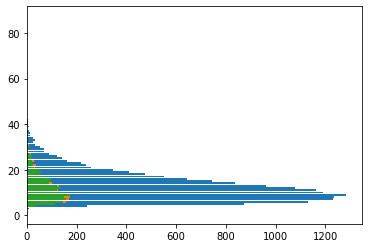

In [ ]:
try:
    del idx, masks, segments
except:
    pass

histo_plot_data = np.zeros((3,87))
# Set max length of the sentence
maxlen=72

# I really should be using data cleaning that I used for Word Embedding, but let's have something working first.
def bert_tokenize(corpus, dataset_str):
    histo_plot_data = np.zeros((87))
    # corpus = data_train["sentence_cleaned"]
    idx, masks, segments = [], [], []
    longest = 0
    longest_index = 0;
    feedback_sum = 0

    for i, element in enumerate(corpus):

        tmp = tokenizer(element)
        idx.append(tmp["input_ids"])
        masks.append(tmp["attention_mask"])
        # segments.append(tmp["token_type_ids"])
        
        if len(tmp["input_ids"]) > longest:
            longest = len(tmp["input_ids"])
            longest_index = i

        histo_plot_data[len(tmp["input_ids"])-1] += 1
        feedback_sum += len(tmp["input_ids"])

        # corpus_tokenized.append(tmp)
    print(f"{dataset_str}: Longest sentence using BERT Tokenization is {longest} at index {longest_index}.")
    print(f"Average ID length: {feedback_sum/len(corpus)}")

    for i, element in enumerate(idx):
        tmp = maxlen - len(element)
        if tmp > 0:
            idx[i] += tmp*[0]
            masks[i] += tmp*[0]
            # segments[i] += tmp*[1]
        else:
            idx[i] = idx[i][0:maxlen]
            idx[i][maxlen-1] = 102
            masks[i] = masks[i][0:maxlen]
            # segments[i] = segments[i][0:maxlen]
    return [np.asarray(idx, dtype='int32'), np.asarray(masks, dtype='int32')], histo_plot_data

X_train, histo_plot_data[0,:]  = bert_tokenize(data_train["sentence_cleaned"], 'X_train')
X_val, histo_plot_data[1,:] = bert_tokenize(data_val["sentence_cleaned"], 'X_val')
X_test, histo_plot_data[2,:] = bert_tokenize(data_test["sentence_cleaned"], 'X_test')

# X_train=[np.asarray(idx, dtype='int32'), 
#          np.asarray(masks, dtype='int32')]

# Plotting the ID histogram to see the distribution
import matplotlib.pyplot as plt
plt.barh(range(1,maxlen+1), histo_plot_data[0,:])
plt.barh(range(1,maxlen+1), histo_plot_data[1,:])
plt.barh(range(1,maxlen+1), histo_plot_data[2,:])


In [ ]:
# X_train=[np.asarray(idx, dtype='int32'), 
#          np.asarray(masks, dtype='int32')]#, 
#         #  np.asarray(segments, dtype='int32')]

BERT NN

In [ ]:
from keras.models import Sequential
from keras import layers, models, optimizers
import keras
import tensorflow as tf

# Inputs
idx = layers.Input((maxlen), dtype='int32',name='input_idx')
masks = layers.Input((maxlen), dtype='int32',name='input_masks')
# segments = layers.Input((maxlen), dtype='int32',name='input_segments')

# Pre-trained BERT
# we already import nlp above, we are using that.

# nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')
bert_out = nlp([idx, masks])

# fine-tuning
x = layers.GlobalAveragePooling1D()(bert_out[0])
# x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
# x = layers.Dense(64, activation='sigmoid')(x)
y_out = layers.Dense(6, activation='softmax')(x)

model = models.Model([idx, masks], y_out)

# The BERT model is pre-trained; we don't need to train that layer. Only train the last two Dense layers basically
for layer in model.layers[:4]:
    layer.trainable=False

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
            #   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
            #   metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam',
            #   optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_idx (InputLayer)         [(None, 72)]         0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 72)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_idx[0][0]',              
 BertModel)                     ast_hidden_state=(N               'input_masks[0][0]']            
                                one, 72, 768),                                                    
                                 hidden_states=None                                         

In [ ]:
from  IPython import display
# from matplotlib import pyplot as plt

# import numpy as np

# import pathlib
# import shutil
# import tempfile

# logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
# shutil.rmtree(logdir, ignore_errors=True)

In [ ]:
# !pip install git+https://github.com/tensorflow/docs
# import tensorflow_docs as tfdocs
# import tensorflow_docs.modeling
# import tensorflow_docs.plots

In [ ]:
# def get_callbacks(name):
def get_callbacks():
  return [
    # tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4),
    # tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [ ]:
history = model.fit(x=X_train, y=data_train['emotion_enc'], batch_size=100, epochs=1,
                    shuffle=True, verbose=1, callbacks=get_callbacks(),
                    validation_data=[X_val, data_val['emotion_enc']])

160/160 [==============================] - 102s 593ms/step - loss: 1.2564 - accuracy: 0.5331 - val_loss: 1.0691 - val_accuracy: 0.6005


#### Doing some other testing here

In [ ]:
# Get feature matrix
# import re

# corpus = data_train["sentence"]

# # Choose large maximum length as BERT splits made-up word into subtokens until it recognizes a word
# # In our case, the longest sentence is 300 characters, so I'm just going to set maxlen to 300 for now
# maxlen = 50

# # add special tokens
# maxqnans = int((maxlen-20)/2)
# corpus_tokenized = ["[CLS] "+
#              " ".join(tokenizer.tokenize(re.sub(r'[^\w\s]+|\n', '', 
#              str(txt).lower().strip()))[:maxqnans])+
#              " [SEP] " for txt in corpus]

# # generate masks
# masks = [[1]*len(txt.split(" ")) + [0]*(maxlen - len(txt.split(" "))) for txt in corpus_tokenized]

# # Padding
# txt2seq = [txt + " [PAD]"*(maxlen-len(txt.split(" "))) if len(txt.split(" ")) != maxlen else txt for txt in corpus_tokenized]

# # Generate idx
# idx = [tokenizer.encode(seq.split(" ")) for seq in txt2seq]

# ## generate segments
# segments = [] 
# for seq in txt2seq:
#     temp, i = [], 0
#     for token in seq.split(" "):
#         temp.append(i)
#         if token == "[SEP]":
#              i += 1
#     segments.append(temp)

# ## feature matrix
# X_train = [np.asarray(idx, dtype='int32'), 
#            np.asarray(masks, dtype='int32'), 
#            np.asarray(segments, dtype='int32')]


In [ ]:
# i = 3
# print("txt: ", data_train["sentence"].iloc[0])
# print("tokenized:", [tokenizer.convert_ids_to_tokens(idx) for idx in X_train[0][i].tolist()])
# print("idx: ", X_train[0][i])
# print("mask: ", X_train[1][i])
# print("segment: ", X_train[2][i])

In [ ]:
# # Testing embedding with the BERT model
# # Hidden layer with embeddings
# txt = "bank river"
# input_ids = np.array(tokenizer.encode(txt))[None, :]
# embedding = nlp(input_ids)
# embedding[0][0]

In [ ]:
# !pip install "tensorflow-text==2.8.*"
# !pip install tf-models-official==2.7.0
# !pip install official.nlp

# import tensorflow as tf
# import tensorflow_hub as hub
# import tensorflow_text as text
# from official.nlp import optimization

In [ ]:
#@title ~Commented Out: Choose a BERT model to fine-tune~

# bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

# map_name_to_handle = {
#     'bert_en_uncased_L-12_H-768_A-12':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
#     'bert_en_cased_L-12_H-768_A-12':
#         'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
#     'bert_multi_cased_L-12_H-768_A-12':
#         'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
#     'small_bert/bert_en_uncased_L-2_H-128_A-2':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
#     'small_bert/bert_en_uncased_L-2_H-256_A-4':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
#     'small_bert/bert_en_uncased_L-2_H-512_A-8':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
#     'small_bert/bert_en_uncased_L-2_H-768_A-12':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
#     'small_bert/bert_en_uncased_L-4_H-128_A-2':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
#     'small_bert/bert_en_uncased_L-4_H-256_A-4':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
#     'small_bert/bert_en_uncased_L-4_H-512_A-8':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
#     'small_bert/bert_en_uncased_L-4_H-768_A-12':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
#     'small_bert/bert_en_uncased_L-6_H-128_A-2':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
#     'small_bert/bert_en_uncased_L-6_H-256_A-4':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
#     'small_bert/bert_en_uncased_L-6_H-512_A-8':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
#     'small_bert/bert_en_uncased_L-6_H-768_A-12':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
#     'small_bert/bert_en_uncased_L-8_H-128_A-2':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
#     'small_bert/bert_en_uncased_L-8_H-256_A-4':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
#     'small_bert/bert_en_uncased_L-8_H-512_A-8':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
#     'small_bert/bert_en_uncased_L-8_H-768_A-12':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
#     'small_bert/bert_en_uncased_L-10_H-128_A-2':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
#     'small_bert/bert_en_uncased_L-10_H-256_A-4':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
#     'small_bert/bert_en_uncased_L-10_H-512_A-8':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
#     'small_bert/bert_en_uncased_L-10_H-768_A-12':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
#     'small_bert/bert_en_uncased_L-12_H-128_A-2':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
#     'small_bert/bert_en_uncased_L-12_H-256_A-4':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
#     'small_bert/bert_en_uncased_L-12_H-512_A-8':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
#     'small_bert/bert_en_uncased_L-12_H-768_A-12':
#         'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
#     'albert_en_base':
#         'https://tfhub.dev/tensorflow/albert_en_base/2',
#     'electra_small':
#         'https://tfhub.dev/google/electra_small/2',
#     'electra_base':
#         'https://tfhub.dev/google/electra_base/2',
#     'experts_pubmed':
#         'https://tfhub.dev/google/experts/bert/pubmed/2',
#     'experts_wiki_books':
#         'https://tfhub.dev/google/experts/bert/wiki_books/2',
#     'talking-heads_base':
#         'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
# }

# map_model_to_preprocess = {
#     'bert_en_uncased_L-12_H-768_A-12':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'bert_en_cased_L-12_H-768_A-12':
#         'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
#     'small_bert/bert_en_uncased_L-2_H-128_A-2':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-2_H-256_A-4':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-2_H-512_A-8':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-2_H-768_A-12':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-4_H-128_A-2':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-4_H-256_A-4':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-4_H-512_A-8':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-4_H-768_A-12':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-6_H-128_A-2':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-6_H-256_A-4':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-6_H-512_A-8':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-6_H-768_A-12':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-8_H-128_A-2':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-8_H-256_A-4':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-8_H-512_A-8':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-8_H-768_A-12':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-10_H-128_A-2':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-10_H-256_A-4':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-10_H-512_A-8':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-10_H-768_A-12':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-12_H-128_A-2':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-12_H-256_A-4':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-12_H-512_A-8':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'small_bert/bert_en_uncased_L-12_H-768_A-12':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'bert_multi_cased_L-12_H-768_A-12':
#         'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
#     'albert_en_base':
#         'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
#     'electra_small':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'electra_base':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'experts_pubmed':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'experts_wiki_books':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#     'talking-heads_base':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
# }

# tfhub_handle_encoder = map_name_to_handle[bert_model_name]
# tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

# print(f'BERT model selected           : {tfhub_handle_encoder}')
# print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

In [ ]:
# bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
# text_test = ["this is an amazing movie"]
# text_preprocessed = bert_preprocess_model(text_test)

# print(f'Keys       : {list(text_preprocessed.keys())}')
# print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
# print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
# print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
# print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

In [ ]:
# Testing the tokenizer model...

# text_test = ["this is an amazing movie", "this is a crappy move on your part"]
# # text_preprocessed = bert_preprocess_model(text_test)
# text_preprocessed = tokenizer(text_test)
# print(text_preprocessed)

#### Histogram: Uncleaned Sentences

Let's find out how long the uncleaned sentence is, since the example link does not do data cleaning on the sentences in the sense that common stop words are still provided.

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train["sentence"])
dic_vocabulary = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(data_train["sentence"])
X_test = tokenizer.texts_to_sequences(data_test["sentence"])
X_val = tokenizer.texts_to_sequences(data_val["sentence"])

vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# string_name = ['X_train', 'X_test', 'X_val']
dict_data = {'X_train': X_train,
             'X_test': X_test,
             'X_val': X_val}
histo_plot_data = np.zeros((3,66))

tmp_counter = 0;
for key, value in dict_data.items():
    feedback = 0;
    feedback_sum = 0;
    for i in value:
        histo_plot_data[tmp_counter, len(i)-1] += 1
        feedback_sum += len(i)
        if len(i) > feedback:
            feedback = len(i)
    print(f"{key}, Longest ID: {feedback}, Average ID length: {feedback_sum/len(value)}")
    tmp_counter += 1
del tmp_counter

# Longest sentence has 35 elements. Average is around 10.
# TODO: This value, which influences padding, should be adjusted I think...
# maxlen = 20

# Delete unneeded variables
del X_train, X_test, X_val, vocab_size, dic_vocabulary, tokenizer, feedback
del feedback_sum, dict_data, tmp_counter, i, key, value

X_train, Longest ID: 66, Average ID length: 19.1663125
X_test, Longest ID: 60, Average ID length: 18.634
X_val, Longest ID: 61, Average ID length: 18.3535


<BarContainer object of 66 artists>

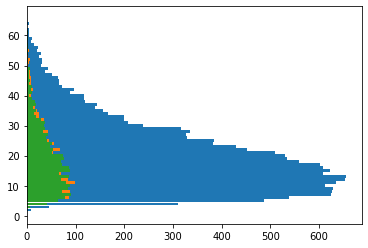

In [ ]:
# Plotting the ID histogram to see the distribution
import matplotlib.pyplot as plt

plt.barh(range(1,66+1), histo_plot_data[0,:])
plt.barh(range(1,66+1), histo_plot_data[1,:])
plt.barh(range(1,66+1), histo_plot_data[2,:])

### METHOD 1: Word Embedding

I did pre-processing, word stemming, and stuff like that in Data Cleaning. The simplest way avoid words not being found in a database is if word stemming is not performed on the dataset (or as I just found out, use lemmization instead. More computationally complex but better for actually working with word embedding techniques (I think)).

Partial reference: Find words in the Word2VecKeyedVector (using 2.3 in source https://github.com/adsieg/Multi_Text_Classification/blob/master/%5BIntroduction%5D%20-%20Big%20tutorial%20-%20Text%20Classification.ipynb) by using `Word2VecKeyedVector.index2word`. This returns a list of the word2vec array.

Instructions used for pre-processing (this part): https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794 (as posted on Feb.17)

For CNN (not attempted): https://medium.com/saarthi-ai/sentence-classification-using-convolutional-neural-networks-ddad72c7048c

In [ ]:
# DO NOT RUN THIS BLOCK MORE THAN ONCE IN ONE SESSION
# Import gensim data
import gensim.downloader as api
import gensim
# Load a pre-trained word embedding model
# Gensim data obtained from https://github.com/RaRe-Technologies/gensim-data (official source)
word_embed = api.load('glove-twitter-25')
# word_embed = api.load('word2vec-google-news-300') # This is 1.6GB... good luck doing this on Google Colab...
# model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

print(api.load("glove-twitter-25", return_path=True))
# print(api.load('word2vec-google-news-300', return_path=True))

# Check dimension of word vectors
# model.vector_size

[==================================================] 100.0% 104.8/104.8MB downloaded
/root/gensim-data/glove-twitter-25/glove-twitter-25.gz


#### Pre-Processing
Using Keras for Preprocessing. Steps taken:
1. Called the Tokenizer object
2. Added Training Set Vocabulary to the Tokenizer object (`fit_on_texts`)
    * Viewed the added vocabulary using `tokenizer.word_index` command.
3. Convert all text to numeric values using `text_to_sequences` method function
4. Padded the length of every sample so that the input matrix would be equal in size

In [ ]:
data_train.head()

,sentence,emotion,emotion_enc,sentence_cleaned
0,i didnt feel humiliated,sadness,4,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,4,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,anger,0,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,3,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,anger,0,feeling grouchy


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train["sentence_cleaned"])
dic_vocabulary = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(data_train["sentence_cleaned"])
X_test = tokenizer.texts_to_sequences(data_test["sentence_cleaned"])
X_val = tokenizer.texts_to_sequences(data_val["sentence_cleaned"])

vocab_size = len(tokenizer.word_index) + 1

Finding out which data set has the longest "sentence" a.k.a. useful words that we did not eliminate via lemmization.

In [ ]:
# string_name = ['X_train', 'X_test', 'X_val']
dict_data = {'X_train': X_train,
             'X_test': X_test,
             'X_val': X_val}
histo_plot_data = np.zeros((3,35))

tmp_counter = 0;
for key, value in dict_data.items():
    feedback = 0;
    feedback_sum = 0;
    for i in value:
        histo_plot_data[tmp_counter, len(i)-1] += 1
        feedback_sum += len(i)
        if len(i) > feedback:
            feedback = len(i)
    print(f"{key}, Longest ID: {feedback}, Average ID length: {feedback_sum/len(value)}")
    tmp_counter += 1
del tmp_counter

# Longest sentence has 35 elements. Average is around 10.
# TODO: This value, which influences padding, should be adjusted I think...
maxlen = 20

X_train, Longest ID: 35, Average ID length: 9.3530625
X_test, Longest ID: 30, Average ID length: 8.85
X_val, Longest ID: 28, Average ID length: 8.764


<BarContainer object of 35 artists>

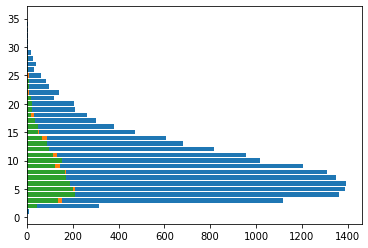

In [ ]:
# Plotting the ID histogram to see the distribution
import matplotlib.pyplot as plt

plt.barh(range(1,35+1), histo_plot_data[0,:])
plt.barh(range(1,35+1), histo_plot_data[1,:])
plt.barh(range(1,35+1), histo_plot_data[2,:])

Pad each sample to the same length.

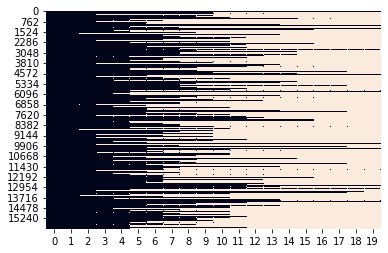

In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

# Honestly don't know what this is doing, I just followed the website's instructions
# Looks like this shows the padding heat map or something similar to that
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

Obtain the Embedding Matrix, which is necessary for the machine learning algorithm.

In [ ]:
embeddings = np.zeros((len(dic_vocabulary)+1, 25))
counter=0
for word, idx in dic_vocabulary.items():
    # embeddings[idx] = word_embed[word]
    try:
        # Reminder: word_embed is the pre-trained word embedding model...
        embeddings[idx] = word_embed[word]
    except:
        counter += 1
        pass

print(f"Number of words in dictionary that have been assigned a matrix of 0's: {counter}")

# word = "data"
# print("dic[word]:", dic_vocabulary[word], "|idx")
# print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
#       "|vector")

Number of words in dictionary that have been assigned a matrix of 0's: 872


#### Neural Network

Referencing source: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

In [ ]:
from keras.models import Sequential
from keras import layers, models, optimizers
import keras

def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name='attention')(x)
    x = layers.multiply([inputs, x])
    return x

# input
x_in = layers.Input(shape=(maxlen,))

# embedding
# trainable=False means that these embedding weights will not change. What if they did though?
x = layers.Embedding(input_dim=embeddings.shape[0],
                     output_dim=embeddings.shape[1],
                     weights=[embeddings],
                     input_length=maxlen, trainable=True)(x_in)

# apply attention
x = attention_layer(x, neurons=maxlen)

# 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=maxlen, dropout=0.2, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=maxlen, dropout=0.2))(x)

# final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(6, activation='softmax')(x)

model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 20, 25)       336975      ['input_5[0][0]']                
                                                                                                  
 permute_4 (Permute)            (None, 25, 20)       0           ['embedding_4[0][0]']            
                                                                                                  
 dense_9 (Dense)                (None, 25, 20)       420         ['permute_4[0][0]']              
                                                                                            

In [ ]:
# The fitting method should be placed in a variable so that results can be easily extracted later...
# For now, I would like to see training happening in real time, so making it verbose I guess.
# Still need to adjust hyper-parameters for better results... if I can get better results.
# batch_size=256 (default given on the website)
model.fit(x=X_train, y=data_train['emotion_enc'], batch_size=32, epochs=20,
                     shuffle=True, verbose=1, validation_data=[X_val, data_val['emotion_enc']])

Epoch 1/20
500/500 [==============================] - 21s 29ms/step - loss: 1.4924 - accuracy: 0.4114 - val_loss: 1.3052 - val_accuracy: 0.5155
Epoch 2/20
500/500 [==============================] - 13s 25ms/step - loss: 1.2320 - accuracy: 0.5321 - val_loss: 1.1119 - val_accuracy: 0.5715
Epoch 3/20
500/500 [==============================] - 13s 25ms/step - loss: 1.0116 - accuracy: 0.6001 - val_loss: 0.8995 - val_accuracy: 0.6400
Epoch 4/20
500/500 [==============================] - 13s 25ms/step - loss: 0.7826 - accuracy: 0.6952 - val_loss: 0.7254 - val_accuracy: 0.7350
Epoch 5/20
500/500 [==============================] - 13s 25ms/step - loss: 0.6021 - accuracy: 0.7732 - val_loss: 0.5989 - val_accuracy: 0.7830
Epoch 6/20
500/500 [==============================] - 14s 29ms/step - loss: 0.4814 - accuracy: 0.8194 - val_loss: 0.4981 - val_accuracy: 0.8325
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 0.3927 - accuracy: 0.8574 - val_loss: 0.4569 - val_accuracy:

Test data on the fitted model using `model.evaluate()`. Also get the probabilities of each sentence via `model.predict()`

In [ ]:
model.evaluate(X_test, data_test["emotion_enc"], batch_size=1)
model.predict(X_test)

2000/2000 [==============================] - 13s 5ms/step - loss: 0.4022 - accuracy: 0.8830


array([[5.2568888e-05, 2.1097869e-05, 4.4417099e-04, 5.7640176e-07,
        9.9948114e-01, 4.1913924e-07],
       [8.9937239e-05, 5.2907642e-05, 2.0784813e-05, 1.3567708e-07,
        9.9983609e-01, 1.5043787e-07],
       [1.1101728e-05, 9.8037917e-06, 2.3443909e-05, 6.2540195e-08,
        9.9995542e-01, 6.2094820e-08],
       ...,
       [4.5340485e-08, 1.3153849e-08, 9.9998450e-01, 1.3308581e-05,
        2.1206949e-06, 1.0057495e-08],
       [7.6205065e-06, 4.2420129e-06, 9.9926525e-01, 6.4096239e-04,
        7.4186173e-05, 7.6518290e-06],
       [4.0333030e-06, 4.6915185e-02, 8.8759256e-04, 6.3963824e-05,
        1.4737179e-05, 9.5211440e-01]], dtype=float32)